In [1]:
!pip install -r req

In [18]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchsummary import summary

In [19]:
mpl.style.use('dark_background')
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cpu


# Uncertainty Quantification

## Types of uncertainty

**Epistemic (or systematic) uncertainty** is related to inadequate modelling of the data-generating process due to limited data and prior knowledge. It is due to properties of the data generation that one could in principle know, but does not.

**Aleatoric (or statistical) uncertainty** is due to stochasticity inherent to the data-generating process itself. This differs from systematic uncertainty in the sense that aleatoric uncertainty cannot be removed but must rather be modelled by estimation of its size.

Besides quantifying the uncertainties, another goal of uncertainty quantification is to reduce epistemic uncertainties to aleatoric ones.

## Uncertainty and neural networks
Neural networks are well-known to be powerful function approximators and they posess good interpolation abilities. Their ability to extrapolate (or generalize) to the outside of the training data domain however is often poor while the probabilities they assign their predictions in these cases often stay very high.

## Data generating process with aleatory uncertainty
Let $f: \mathbb{R} \rightarrow \mathbb{R}$ be the data-generating process for the example considered in this notebook. The function will include some stochasticity, simulated here by the normal random variable $\epsilon$. We can write the mapping of any input $x_i$ to the output $y_i$ as

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$

Concretely, Let

$$f(x_i) = 2 \sin(x_i + 0.5) + 3 \cos(0.7 x_i)$$

Let's sample some training, validation and test data from this function and visualize it.

In [20]:
# Data generating function and data
N_SAMPLES = 200  # Training data samples
SIGMA = 0.5  # Data standard deviation

SAVE_PATH = 'checkpoints'
BATCH_SIZE = 16

In [21]:
# Data generating function
def f(x, sigma=0):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x)
    eps = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return y + eps

In [22]:
# Training data
x_1 = np.random.uniform(-12, -2, size=N_SAMPLES // 2)
x_2 = np.random.uniform(0, 10, size=N_SAMPLES // 2)
x_train = np.concatenate([x_1, x_2]).reshape(N_SAMPLES, 1)
y_train = f(x_train, sigma=SIGMA)

# Validation data
x_1 = np.random.uniform(-12, -2, size=N_SAMPLES // (2 * 5))
x_2 = np.random.uniform(0, 10, size=N_SAMPLES // (2 * 5))
x_val = np.concatenate([x_1, x_2]).reshape(N_SAMPLES // 5, 1)
y_val = f(x_val, sigma=SIGMA)

# Test data (
x_test = np.random.uniform(-15, 15, size=N_SAMPLES // 5).reshape(N_SAMPLES // 5, 1)
y_test = f(x_test, sigma=SIGMA)

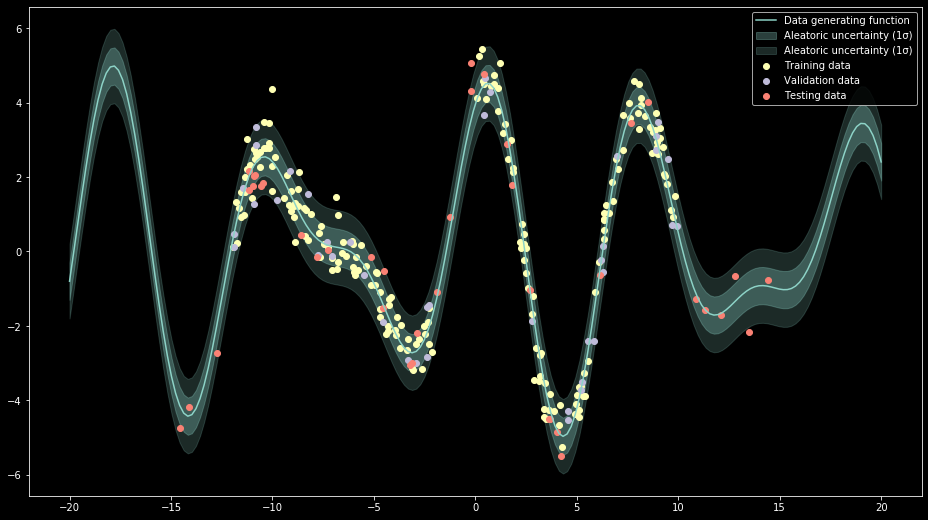

In [23]:
x_plot = np.linspace(-20, 20, num=200)
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, f(x_plot), label='Data generating function', color='C0')
ax.fill_between(x_plot, f(x_plot) - SIGMA, f(x_plot) + SIGMA, alpha=0.3, color='C0', label='Aleatoric uncertainty (1σ)')
ax.fill_between(x_plot, f(x_plot) - 2 * SIGMA, f(x_plot) + 2 * SIGMA, alpha=0.2, color='C0', label='Aleatoric uncertainty (1σ)')
ax.scatter(x_train, y_train, color='C1', label='Training data')
ax.scatter(x_val, y_val, color='C2', label='Validation data')
ax.scatter(x_test, y_test, color='C3', label='Testing data')
ax.legend()

## Datasets and training loops
The below defines datasets on the sampled data and the training and test loop code.

In [24]:
# Dataset and loader
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataset_val = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [81]:
def train(epoch, model, loss, optimizer, dataloader):
    model.train()
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
        x_batch.to(device)
        y_batch.to(device)
        optimizer.zero_grad()
        # mu_pred, logvar_pred = model.forward(x_batch)
        output = model.forward(x_batch)
        loss_batch = loss(y_batch, output)
        loss_batch.backward()
        optimizer.step()
        total_loss += loss_batch.item()

    return total_loss / i


def test(epoch, model, loss, dataloader, eval_mode=True):
    if eval_mode:
        model.eval()
    else:
        model.train()
    total_loss = 0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
            x_batch.to(device)
            y_batch.to(device)
            #mu_pred, logvar_pred = model.forward(x_batch)
            output = model.forward(x_batch)
            loss_batch = loss(y_batch, output)
            total_loss += loss_batch.item()

    return total_loss / i

# Methods for modelling uncertainty

## Monte Carlo Dropout
As proposed in \[1\], the widely used regularization technique *Dropout* can be used to provide uncertainty estimates for a models predictions. This is in line with the interpretation of dropout as a form of model ensembling or averaging \[2\].

Typically, dropout is applied at train-time and deactivated at test-time in order to exploit the full power of the "model ensemble". If instead we also apply dropout at test-time and do several forward passes of the same input $x$, we can expect to get a different prediction every time with some variance. We can use this to deduce an empirical distribution over the outputs given the inputs $p(y|x)$. In turn. we can then use this distribution to estimate an empirical mean and variance of the mean of the predictions.

We expect that the empirical variance of the mean is low for inputs originating from dense regions of the input space since more sub-networks were presented with data from these regions. In more sparsely sampled regions of the input space or regions with no data at all, we expect the spread in sub-network behaviour to be higher. This corresponds to the desired behavior for the uncertainty estimation.

In [196]:
N_EPOCHS = 350
DIMS = [1, 20, 20, 20, 1]
RATES = [0.0, 0.2, 0.2, 0.1]

In [226]:
class MCDModel(nn.Module):
    def __init__(self, dims=[1, 20, 20, 20, 1], rates=[0.3, 0.2, 0.2, 0.1], batchnorm=False):
        """
        Args:
            dims (list): Number of units in each of the layers including input and output.
            rates (list): Probability of dropping any activation in the representation immediately before any linear transformation.
        """
        super().__init__()
        self.layers = []

        self.layers.append(nn.Dropout(p=rates[0]))
        self.layers.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(dims[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=rates[i]))
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))

        for i, layer in enumerate(self.layers):
            setattr(self, layer.__class__.__name__ + f'_{i}', layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, x, n_repeats=40):
        self.train()
        y_pred = []
        for i in range(n_repeats):
            y_pred.append(self.forward(x))
        y_pred = torch.stack(y_pred)  # Create new axis (Repeats, Batch, Dims)
        return torch.mean(y_pred, axis=0), torch.var(y_pred, axis=0)


In [227]:
# Initialize model parameters and setup
mcd_model = MCDModel(dims=DIMS, rates=RATES)
mcd_model.to(device)
print(summary(model=mcd_model, input_size=(1,), device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                    [-1, 1]               0
            Linear-2                   [-1, 20]              40
              ReLU-3                   [-1, 20]               0
           Dropout-4                   [-1, 20]               0
            Linear-5                   [-1, 20]             420
              ReLU-6                   [-1, 20]               0
           Dropout-7                   [-1, 20]               0
            Linear-8                   [-1, 20]             420
              ReLU-9                   [-1, 20]               0
          Dropout-10                   [-1, 20]               0
           Linear-11                    [-1, 1]              21
Total params: 901
Trainable params: 901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

In [228]:
mse_loss = nn.MSELoss(reduction='mean')
mse_loss.to(device)
optimizer = optim.Adam(mcd_model.parameters(), lr=1e-3)

In [229]:
for epoch in range(N_EPOCHS):
    train_loss = train(epoch, mcd_model, mse_loss, optimizer, dataloader_train)
    val_loss = test(epoch, mcd_model, mse_loss, dataloader_val)
    test_loss = test(epoch, mcd_model, mse_loss, dataloader_test)
    print(f'Epoch {epoch:3d} | Train loss {train_loss:2.3f} | Val loss {val_loss:2.3f} | Test loss {test_loss:2.3f}', end='\r')

torch.save(mcd_model.state_dict(), os.path.join(SAVE_PATH, 'mcd_model_state_dict.pkl'))

Epoch 349 | Train loss 1.452 | Val loss 1.015 | Test loss 6.422

tensor([1.0417, 0.9701, 0.7809, 0.8859, 0.8377, 0.9566, 0.7313, 0.8886, 0.7174,
        0.7101, 0.9032, 0.8844, 0.7289, 0.7220, 0.8029, 0.7734, 0.7865, 0.7551,
        0.6008, 0.7061, 0.8397, 0.8258, 0.6233, 0.7294, 0.6985, 0.7042, 0.4352,
        0.7747, 0.5456, 0.5038, 0.4235, 0.5288, 0.5409, 0.6136, 0.5238, 0.6094,
        0.6325, 0.5721, 0.4021, 0.4564, 0.4341, 0.4777, 0.3449, 0.5343, 0.5260,
        0.4061, 0.4645, 0.5120, 0.4104, 0.3716, 0.3320, 0.4419, 0.3993, 0.3649,
        0.3500, 0.3087, 0.3486, 0.2981, 0.5002, 0.3030, 0.3227, 0.2322, 0.3758,
        0.3327, 0.4162, 0.3414, 0.5035, 0.2622, 0.3882, 0.4158, 0.4197, 0.4056,
        0.3886, 0.7538, 0.2947, 0.4183, 0.3811, 0.4205, 0.3885, 0.3526, 0.4322,
        0.4257, 0.4901, 0.4779, 0.5200, 0.3647, 0.4692, 0.7407, 0.3452, 1.2977,
        0.4945, 0.6016, 0.7493, 0.8716, 1.1106, 1.5719, 1.2095, 1.1135, 0.7343,
        1.0207, 1.0802, 0.7612, 0.9589, 0.7139, 0.8471, 0.9732, 1.0174, 1.0247,
        0.7254, 1.1317, 1.0353, 0.9163, 

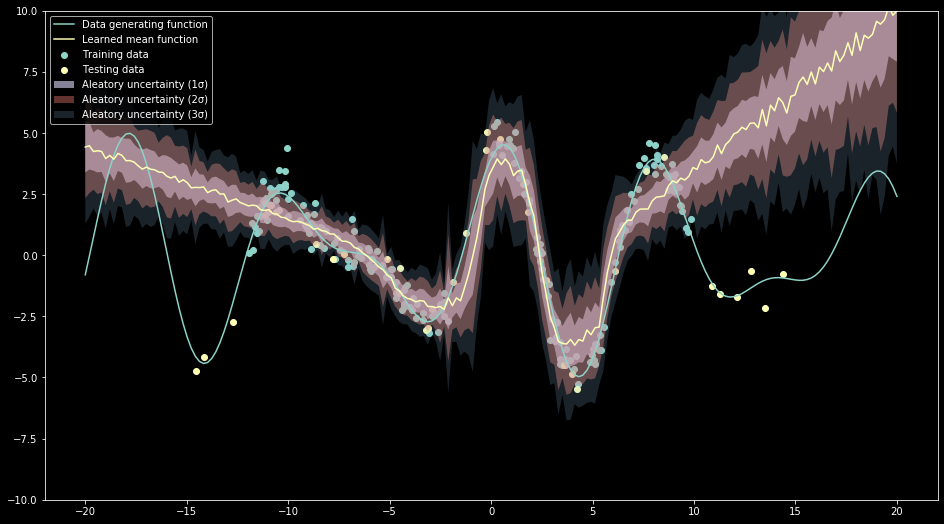

In [230]:
def plot_learned_function(model, x_data):
    with torch.no_grad():
        x_data_tensor = torch.Tensor(x_data.reshape(-1, 1))
        x_data_tensor.to(device)
        learned_function, aleatory_var = model.predict(x_data_tensor)
        learned_function = learned_function.flatten()
        aleatory_std = aleatory_var.flatten().sqrt()

    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.plot(x_data, f(x_data, sigma=0), label='Data generating function')
    ax.scatter(x_train, y_train, label='Training data')
    ax.scatter(x_test, y_test, label='Testing data')
    ax.plot(x_data, learned_function, label='Learned mean function')
    ax.fill_between(x_data, learned_function - 1 * aleatory_std, learned_function + 1 * aleatory_std, alpha=0.7, label='Aleatory uncertainty (1σ)')
    ax.fill_between(x_data, learned_function - 2 * aleatory_std, learned_function + 2 * aleatory_std, alpha=0.4, label='Aleatory uncertainty (2σ)')
    ax.fill_between(x_data, learned_function - 3 * aleatory_std, learned_function + 3 * aleatory_std, alpha=0.2, label='Aleatory uncertainty (3σ)')
    ax.set_ylim([-10, 10])
    ax.legend()

plot_learned_function(mcd_model, x_plot)

## Distributional Parameter Learning

In [ ]:
N_EPOCHS = 350

In [33]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, mu_pred, logvar_pred):
        return torch.mean(logvar_pred / (2) + (mu_true - mu_pred).pow(2) / (2 * logvar_pred.exp()), axis=0)

In [222]:
class DPLModel(nn.Module):
    """Distributional Parameter Learning Model using Gaussian"""
    def __init__(self, dims=[1, 20, 20, 20, 2], batchnorm=False):
        super().__init__()
        self.layers = []

        self.layers.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            if batchnorm:
                bn = nn.BatchNorm1d(dims[i])
                self.layers.append(bn)
            elu = nn.ReLU()
            self.layers.append(elu)
            lin = nn.Linear(dims[i], dims[i + 1])
            self.layers.append(lin)

        for i, layer in enumerate(self.layers):
            setattr(self, layer.__class__.__name__ + f'_{i}', layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        mu = x[..., 0:1]
        logvar = x[..., 1:2]
        return mu, logvar

In [223]:
# Initialize model parameters and setup
dpl_model = DPLModel()
dpl_model.to(device)
print(summary(model=dpl_model, input_size=(1,), device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              40
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 20]             420
              ReLU-4                   [-1, 20]               0
            Linear-5                    [-1, 2]              42
Total params: 502
Trainable params: 502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
None


In [224]:
gaussian_nll_loss = GaussianNLLLoss()
gaussian_nll_loss.to(device)
optimizer = optim.Adam(dpl_model.parameters(), lr=1e-3)

In [225]:
for epoch in range(N_EPOCHS):
    train_loss = train(epoch, dpl_model, gaussian_nll_loss, optimizer, dataloader_train)
    val_loss = test(epoch, dpl_model, gaussian_nll_loss, dataloader_val)
    test_loss = test(epoch, dpl_model, gaussian_nll_loss, dataloader_test)
    print(f'Epoch {epoch:3d} | Train loss {train_loss:2.3f} | Val loss {val_loss:2.3f} | Test loss {test_loss:2.3f}', end='\r')

torch.save(dpl_model.state_dict(), os.path.join(SAVE_PATH, 'dpl_model_state_dict.pkl'))

Epoch 349 | Train loss 0.048 | Val loss 0.088 | Test loss 1.765

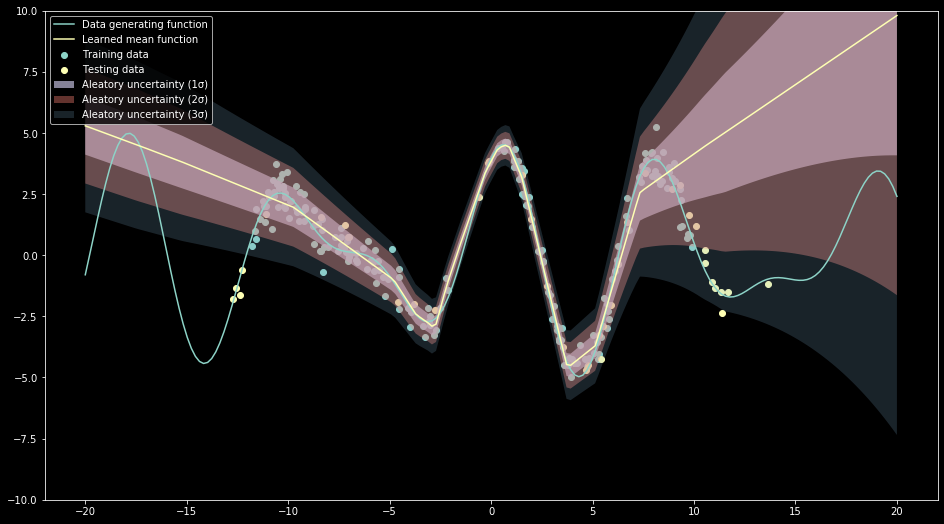

In [226]:
def plot_learned_function(model, x_data):
    with torch.no_grad():
        x_data_tensor = torch.Tensor(x_data.reshape(-1, 1))
        x_data_tensor.to(device)
        learned_function, aleatory_logvar = model.forward(x_data_tensor)
        learned_function = learned_function.flatten()
        aleatory_std = aleatory_logvar.flatten().exp().sqrt()

    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.plot(x_data, f(x_data, sigma=0), label='Data generating function')
    ax.scatter(x_train, y_train, label='Training data')
    ax.scatter(x_test, y_test, label='Testing data')
    ax.plot(x_data, learned_function, label='Learned mean function')
    ax.fill_between(x_data, learned_function - 1 * aleatory_std, learned_function + 1 * aleatory_std, alpha=0.7, label='Aleatory uncertainty (1σ)')
    ax.fill_between(x_data, learned_function - 2 * aleatory_std, learned_function + 2 * aleatory_std, alpha=0.4, label='Aleatory uncertainty (2σ)')
    ax.fill_between(x_data, learned_function - 3 * aleatory_std, learned_function + 3 * aleatory_std, alpha=0.2, label='Aleatory uncertainty (3σ)')
    ax.set_ylim([-10, 10])
    ax.legend()

plot_learned_function(dpl_model, x_plot)



## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression

# References
[1] Yarin Gal. 2017. Uncertainty in Deep Learning. PhD Thesis.

[2] Nitish, Hinton, et al. 2014. Dropout: A Simple Way to Prevent Neural Networks from Overﬁtting.


[10] https://en.wikipedia.org/wiki/Uncertainty_quantification

[11] https://www.inovex.de/blog/uncertainty-quantification-deep-learning/

In [201]:
y_pred = []
for i in range(10):
    y_pred.append(mcd_model.forward(dataset_train[0:5][0]))

y_pred = torch.stack(y_pred)
y_pred.shape

torch.Size([10, 5, 1])